This notebook provides Python scripts to import, compile, modify, graph, and export Solinst transducer data. 

In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import sys
import platform
import glob
import re
import xmltodict
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as tick
from matplotlib.backends.backend_pdf import PdfPages
import statsmodels.tsa.tsatools as tools
from pandas.stats.api import ols
from datetime import datetime
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [6]:
print("Operating System " + platform.system() + " " + platform.release())
print("Python Version " + str(sys.version))
print("Pandas Version " + str(pd.__version__))
print("Numpy Version " + str(np.__version__))
print("Matplotlib Version " + str(matplotlib.__version__))

Operating System Windows 7
Python Version 2.7.8 (default, Jun 30 2014, 16:03:49) [MSC v.1500 32 bit (Intel)]
Pandas Version 0.17.0
Numpy Version 1.9.3
Matplotlib Version 1.4.3


In [7]:
#rootname = '/media/p/Transcend/PROJECTS/UMAR/Phase_II/Data/RAW/'
rootname = 'E:/PROJECTS/UMAR/Data/RAW/'

# Functions 

## Jumpfix

In [73]:
def jumpfix(df,meas, threashold=0.005):
    '''
    removes jumps or jolts in time series data (where offset is lasting)
    df = dataframe to manipulate
    meas = name of field with jolts
    threashold = size of jolt to search for'''
    df['delta'+meas] = df.loc[:,meas].diff()
    jump = df[abs(df['delta'+meas])>threashold]
    jump['cumul'] = jump.loc[:,'delta'+meas].cumsum()
    df['newVal'] = df.loc[:,meas]
    print jump
    for i in range(len(jump)):
        jt = jump.index[i]
        ja = jump['cumul'][i]
        df.loc[jt:,'newVal'] = df[meas].apply(lambda x: x-ja,1)
    df[meas]=df['newVal']
    return df

## getfilename

In [8]:
def getfilename(path):
    '''
    this function extracts the file name without file path or extension
    '''
    return path.split('\\').pop().split('/').pop().rsplit('.', 1)[0]

## new_xle_imp

In [147]:
def new_xle_imp(infile):
    '''
    This function uses an exact file path to upload a Solinst xle file. 
    
    infile = complete file path to input file
    
    RETURNS
    A pandas dataframe containing the transducer data
    '''
    # open text file
    with open(infile) as fd:
        # parse xml
        obj = xmltodict.parse(fd.read(),encoding="ISO-8859-1")
    # navigate through xml to the data
    wellrawdata = obj['Body_xle']['Data']['Log']
    # convert xml data to pandas dataframe
    f = pd.DataFrame(wellrawdata)
    # get header names and apply to the pandas dataframe
    f[str(obj['Body_xle']['Ch2_data_header']['Identification']).title()] = f['ch2']
    
    #CH 3 check
    try:
        f[str(obj['Body_xle']['Ch3_data_header']['Identification']).title()] = f['ch3']
    except(KeyError):
        pass
    
    #CH 2 manipulation
    tempunit = (obj['Body_xle']['Ch2_data_header']['Unit'])
    if tempunit == 'Deg C' or tempunit == u'\N{DEGREE SIGN}' + u'C':
        f[str(obj['Body_xle']['Ch2_data_header']['Identification']).title()] = pd.to_numeric(f['ch2'])
    elif tempunit == 'Deg F' or tempunit == u'\N{DEGREE SIGN}' + u'F': 
        f[str(obj['Body_xle']['Ch2_data_header']['Identification']).title()] = pd.to_numeric(f['ch2'])*0.33456

    
    unit = str(obj['Body_xle']['Ch1_data_header']['Unit']).lower()
    if unit == "feet" or unit == "ft":
        f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] = pd.to_numeric(f['ch1'])
    elif unit == "kpa":
        f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] = pd.to_numeric(f['ch1'])*0.33456
    elif unit == "mbar":
        f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] = pd.to_numeric(f['ch1'])*0.0334552565551
    elif unit == "psi":
        f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] = pd.to_numeric(f['ch1'])*2.306726
    elif unit == "m" or unit == "meters":
        f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] = pd.to_numeric(f['ch1'])*3.28084
    else:
        f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] = pd.to_numeric(f['ch1'])
        print "Unknown Units"
        
    # add extension-free file name to dataframe
    f['name'] = getfilename(infile)
    # combine Date and Time fields into one field
    f['DateTime'] = pd.to_datetime(f.apply(lambda x: x['Date'] + ' ' + x['Time'], 1))
    f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] =  pd.to_numeric(f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()])
    f[str(obj['Body_xle']['Ch2_data_header']['Identification']).title()] =  pd.to_numeric(f[str(obj['Body_xle']['Ch2_data_header']['Identification']).title()])
    
    try:
        f[str(obj['Body_xle']['Ch3_data_header']['Identification']).title()] =  pd.to_numeric(f[str(obj['Body_xle']['Ch3_data_header']['Identification']).title()])
    except(KeyError):
        pass

    f = f.reset_index()
    f = f.set_index('DateTime')
    f = f.drop(['Date','Time','@id','ch1','ch2','index','ms'],axis=1)
    
    f['MeasuredLevel'] = f['Level'] 
    return f


## fcl

In [58]:
def fcl(df, dtObj):
    '''
    finds closest date index in a dataframe to a date object
    
    df = dataframe
    dtObj = date object
    
    taken from: http://stackoverflow.com/questions/15115547/find-closest-row-of-dataframe-to-given-time-in-pandas
    '''
    return df.iloc[np.argmin(np.abs(df.index.to_pydatetime() - dtObj))]

In [210]:
fcl(manualfile, datetime.datetime.strptime('6/3/2015',"%m/%d/%Y"))['aw_spc_uS']

500

## manualset

In [232]:
 def manualset(wellbaro,manualfile,manmeas=0, meas):
    breakpoints = []
    bracketedwls = {}

    for i in range(len(manualfile)+1):
        breakpoints.append(fcl(wellbaro, manualfile.index.to_datetime()[i-1]).name)

    last_man_wl,first_man_wl,last_tran_wl,driftlen = [],[],[],[]

    for i in range(len(manualfile)-1):
        # Break up time series into pieces based on timing of manual measurements
        bracketedwls[i+1] = wellbaro.loc[(wellbaro.index.to_datetime() > breakpoints[i+1])&(wellbaro.index.to_datetime() < breakpoints[i+2])]
        bracketedwls[i+1].loc[:,'diff_wls'] = bracketedwls[i+1].loc[:,meas].diff() 


        bracketedwls[i+1].loc[:,'DeltaLevel'] = bracketedwls[i+1].loc[:,meas] - bracketedwls[i+1].ix[0,meas]
        bracketedwls[i+1].loc[:,'MeasuredDTW'] = fcl(manualfile,breakpoints[i+1])[manmeas] - bracketedwls[i+1].loc[:,'DeltaLevel']

        last_man_wl.append(fcl(manualfile,breakpoints[i+2])[manmeas])
        first_man_wl.append(fcl(manualfile,breakpoints[i+1])[manmeas])
        last_tran_wl.append(float(bracketedwls[i+1].loc[max(bracketedwls[i+1].index.to_datetime()),'MeasuredDTW']))
        driftlen.append(len(bracketedwls[i+1].index))
        bracketedwls[i+1].loc[:,'last_diff_int'] = np.round((last_tran_wl[i]-last_man_wl[i]),4)/np.round(driftlen[i]-1.0,4)
        bracketedwls[i+1].loc[:,'DriftCorrection'] = np.round(bracketedwls[i+1].loc[:,'last_diff_int'].cumsum()-bracketedwls[i+1].loc[:,'last_diff_int'],4)

    wellbarofixed = pd.concat(bracketedwls)
    wellbarofixed.reset_index(inplace=True)
    wellbarofixed.set_index('DateTime',inplace=True)
    # Get Depth to water below casing
    wellbarofixed.loc[:,'DTWBelowCasing'] = wellbarofixed['MeasuredDTW'] - wellbarofixed['DriftCorrection']
    return wellbarofixed


## smoother

In [158]:
def smoother(df, p, win=30, sd=3):
    '''
    remove outliers from a pandas dataframe column and fill with interpolated values
    warning: this will fill all NaN values in the dataframe with the interpolate function
    
    INPUT
    ------
    df= dataframe of interest
    p= column in dataframe with outliers
    win= size of window
    std= number of standard deviations allowed
    
    RETURNS
    ------
    Pandas dataframe with outliers removed
    '''
    df1 = df
    df1.loc[:,'dp'+ p] = df1.loc[:,p].diff()
    df1.loc[:,'ma'+ p] = pd.rolling_mean(df1.loc[:,'dp'+ p], window=win, center=True)
    df1.loc[:,'mst'+p] = pd.rolling_std(df1.loc[:,'dp'+ p], window=win, center=True)
    for i in df.index:
        try:
            if abs(df1.loc[i,'dp'+ p] - df1.loc[i,'ma'+ p]) >= abs(df1.loc[i,'mst'+p]*sd):
                df.loc[i,p]=np.nan
            else:
                df.loc[i,p]=df.loc[i,p]
        except (ValueError):
            try:
                if abs(df1.loc[i,'dp'+ p] - df1.loc[i,'ma'+ p]) >= abs(df1.loc[:,'dp'+p].std()*sd):
                    df.loc[i,p]=np.nan
                else:
                    df.loc[i,p]=df.loc[i,p]
            except (ValueError):
                df.loc[i,p]=df.loc[i,p]

    try:
        df1 = df1.drop(['dp'+p,'ma'+p,'mst'+p],axis=1)
    except(NameError,ValueError):
        pass            
    del df1
    try:
        df = df.drop(['dp'+p,'ma'+p,'mst'+p],axis=1)
    except(NameError,ValueError):
        pass  
    df = df.interpolate(method='time')
    df = df[1:-1]
    return df

## hourly_resample

In [60]:
def hourly_resample(df,bse=0,minutes=60):
    '''
    INPUT
    -----
    df = pandas dataframe containing time series needing resampling
    bse = base time to set; default is zero (on the hour); 
    minutes = sampling recurrance interval in minutes; default is 60 (hourly samples)
    
    RETURNS
    -----
    A pandas dataframe that has been resampled to every hour, at the minute defined by the base (bse)
    
    DESCRIPTION
    -----
    see http://pandas.pydata.org/pandas-docs/dev/generated/pandas.DataFrame.resample.html for more info
    
    This function uses pandas powerful time-series manipulation to upsample to every minute, then downsample to every hour, 
    on the hour.
    
    This function will need adjustment if you do not want it to return hourly samples, or if you are sampling more frequently than
    once per minute.
    
    see http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases
    
    '''
    df = df.resample('1Min') #you can make this smaller to accomodate for a higher sampling frequency
    df = df.interpolate(method='time') #http://pandas.pydata.org/pandas-docs/dev/generated/pandas.Series.interpolate.html
    df = df.resample(str(minutes)+'Min', how='first',closed='left',label='left', base=bse) #modify '60Min' to change the resulting frequency
    return df

## dataendclean

In [87]:
def dataendclean(df,x):
    ## Examine First Value
    firstupper = np.mean(df[x].diff()[2:31]) + np.std(df[x].diff()[2:31])*2.2 # 2.2 std dev.
    firstlower = np.mean(df[x].diff()[2:31]) - np.std(df[x].diff()[2:31])*2.2 # 2.2 std dev.
    firstlev = df[x].diff()[0:2].values[0] # difference of first two values
    firstlev1 = df[x].diff(periods=3)[0:4].values[0] # difference of second two values
    ## Examine Last Value
    lastupper = np.mean(df[x].diff()[-31:-2]) + np.std(df[x].diff()[-31:-2])*2.2 # 2.2 std dev.
    lastlower = np.mean(df[x].diff()[-31:-2]) - np.std(df[x].diff()[-31:-2])*2.2 # 2.2 std dev.
    lastlev = df[x].diff()[-1:].values[0] # difference of last two values
    lastlev1 = df[x].diff(periods=4)[-5:-1].values[0] # difference of last two values

    ## drop first value if 2.2 std dev beyond first 30 values
    if np.abs(firstlev) > 0.1:
        print('jump detected on ' + str(wellname))
        if firstlev > firstupper or firstlev < firstlower:
            df.drop(df.index[0],inplace=True)
            print('drop first on ' + str(wellname))
    ## drop last value if 2.2 std dev beyond last 30 values
    if np.abs(lastlev) > 0.1:
        print('jump detected on ' + str(wellname))
        if lastlev > lastupper or lastlev < lastlower:
            df.drop(df.index[-1],inplace=True)
            print('drop last on ' + str(wellname))
    if np.abs(firstlev1) > 0.1:
        print('jump detected on ' + str(wellname))
        if firstlev1 > firstupper or firstlev1 < firstlower:
            df.drop(df.index[0:2],inplace=True)
            print('drop first 2 on ' + str(wellname))
    ## drop last value if 2.2 std dev beyond last 30 values
    if np.abs(lastlev1) > 0.1:
        print('jump detected on ' + str(wellname))
        if lastlev1 > lastupper or lastlev1 < lastlower:
            df.drop(df.index[-10:-1],inplace=True)
            print('drop last 2 on ' + str(wellname))
    
    return df

## baro_drift_correct

In [88]:
def baro_drift_correct(wellfile,barofile,manualfile,sampint=60,wellelev=4800,stickup=0):
    '''
    INPUT
    -----
    wellfile = pandas dataframe with water level data labeled 'Level'; index must be datetime
    barofile = pandas dataframe with barometric data labeled 'Level'; index must be datetime
    manualfile = pandas dataframe with manual level data in the first column after the index; index must be datetime
    
    sampint = sampling interval in minutes; default 60
    wellelev = site ground surface elevation in feet
    stickup = offset of measure point from ground in feet
    
    OUTPUT
    -----
    wellbarofinal = pandas dataframe with corrected water levels 
    
    This function uses pandas dataframes created using the 

    '''
    #Remove dangling ends
    baroclean = dataendclean(barofile, 'Level')
    wellclean = dataendclean(wellfile, 'Level')
    
    # resample data to make sample interval consistent  
    baro = hourly_resample(baroclean,0,sampint)
    well = hourly_resample(wellclean,0,sampint)
    
    # reassign `Level` to reduce ambiguity
    well['abs_feet_above_levelogger'] = well['Level']
    baro['abs_feet_above_barologger'] = baro['Level']
    
    # combine baro and well data for easy calculations, graphing, and manipulation
    wellbaro = pd.merge(well,baro,left_index=True,right_index=True,how='inner')
    wellbaro['adjusted_levelogger'] =  wellbaro['abs_feet_above_levelogger'] - wellbaro['abs_feet_above_barologger']
    
    breakpoints = []
    bracketedwls = {}

    for i in range(len(manualfile)+1):
        breakpoints.append(fcl(wellbaro, manualfile.index.to_datetime()[i-1]).name)

    last_man_wl,first_man_wl,last_tran_wl,driftlen = [],[],[],[]

    firstupper, firstlower, firstlev, lastupper, lastlower, lastlev = [],[],[],[],[],[]

    for i in range(len(manualfile)-1):
        # Break up time series into pieces based on timing of manual measurements
        bracketedwls[i+1] = wellbaro.loc[(wellbaro.index.to_datetime() > breakpoints[i+1])&(wellbaro.index.to_datetime() < breakpoints[i+2])]
        bracketedwls[i+1]['diff_wls'] = bracketedwls[i+1]['abs_feet_above_levelogger'].diff() 


        bracketedwls[i+1].loc[:,'DeltaLevel'] = bracketedwls[i+1].loc[:,'adjusted_levelogger'] - bracketedwls[i+1].ix[0,'adjusted_levelogger']
        bracketedwls[i+1].loc[:,'MeasuredDTW'] = fcl(manualfile,breakpoints[i+1])[0] - bracketedwls[i+1].loc[:,'DeltaLevel']

        last_man_wl.append(fcl(manualfile,breakpoints[i+2])[0])
        first_man_wl.append(fcl(manualfile,breakpoints[i+1])[0])
        last_tran_wl.append(float(bracketedwls[i+1].loc[max(bracketedwls[i+1].index.to_datetime()),'MeasuredDTW']))
        driftlen.append(len(bracketedwls[i+1].index))
        bracketedwls[i+1].loc[:,'last_diff_int'] = np.round((last_tran_wl[i]-last_man_wl[i]),4)/np.round(driftlen[i]-1.0,4)
        bracketedwls[i+1].loc[:,'DriftCorrection'] = np.round(bracketedwls[i+1].loc[:,'last_diff_int'].cumsum()-bracketedwls[i+1].loc[:,'last_diff_int'],4)

    wellbarofixed = pd.concat(bracketedwls)
    wellbarofixed.reset_index(inplace=True)
    wellbarofixed.set_index('DateTime',inplace=True)
    # Get Depth to water below casing
    wellbarofixed.loc[:,'DTWBelowCasing'] = wellbarofixed['MeasuredDTW'] - wellbarofixed['DriftCorrection']

    # subtract casing height from depth to water below casing
    wellbarofixed.loc[:,'DTWBelowGroundSurface'] = wellbarofixed.loc[:,'DTWBelowCasing'] - stickup #well riser height

    # subtract depth to water below ground surface from well surface elevation
    wellbarofixed.loc[:,'WaterElevation'] = wellelev - wellbarofixed.loc[:,'DTWBelowGroundSurface']
    
    wellbarofinal = smoother(wellbarofixed, 'WaterElevation')
    
    return wellbarofinal
    

## Scat

In [63]:
def Scat(data,bp,wl):
    data['dwl'] = data[wl].diff()
    data['dbp'] = data[bp].diff()

    regression = ols(y=data['dwl'], x=data['dbp'])
    m = regression.beta.x
    b = regression.beta.intercept
    r = regression.r2
    #r = (regression.beta.r)**2
    plt.scatter(y=data['dwl'], x=data['dbp'])

    y_reg = [data['dbp'][i]*m+b for i in range(len(data['dbp']))]

    plt.plot(data['dbp'],y_reg, 
             label='Regression: Y = {m:.4f}X + {b:.5}\nr^2 = {r:.4f}\n BE = {be:.2f} '.format(m=m,b=b,r=r,be=m))
    plt.legend()
    plt.xlabel('Sum of Barometric Pressure Changes (ft)')
    plt.ylabel('Sum of Water-Level Changes (ft)')

## clarks

In [64]:
# clark's method
def clarks(data,bp,wl):
    '''
    clarks method
    Input dataframe (data) with barometric pressure (bp) and water level (wl) data
    Returns slope, intercept, and r squared value'''
    data['dwl'] = data[wl].diff()
    data['dbp'] = data[bp].diff()
    
    data['beta'] = data['dbp']*data['dwl']
    data['Sbp'] = np.abs(data['dbp']).cumsum()
    data['Swl'] = data[['dwl','beta']].apply(lambda x: -1*np.abs(x[0]) if x[1]>0 else np.abs(x[0]), axis=1).cumsum()
    plt.figure()
    plt.plot(data['Sbp'],data['Swl'])
    regression = ols(y=data['Swl'], x=data['Sbp'])
    
    m = regression.beta.x
    b = regression.beta.intercept
    r = regression.r2
    
    y_reg = [data.ix[i,'Sbp']*m+b for i in range(len(data['Sbp']))]

    plt.plot(data['Sbp'],y_reg,
             label='Regression: Y = {m:.4f}X + {b:.5}\nr^2 = {r:.4f}\n BE = {be:.2f} '.format(m=m,b=b,r=r,be=m))
    plt.legend()
    plt.xlabel('Sum of Barometric Pressure Changes (ft)')
    plt.ylabel('Sum of Water-Level Changes (ft)')
    data.drop(['dwl','dbp','Sbp','Swl'], axis=1, inplace=True)
    return m,b,r

## baro_eff

In [95]:
def baro_eff(df,bp,wl,lag=100):
    df.dropna(inplace=True)
    #dwl = df[wl].diff().values[1:-1]
    #dbp = df[bp].diff().values[1:-1]
    dwl = np.subtract(df[wl].values[1:-1],np.mean(df[wl].values[1:-1]))
    dbp = np.subtract(df[bp].values[1:-1],np.mean(df[bp].values[1:-1]))
    df['j_dates'] = df.index.to_julian_date()
    lag_time = df['j_dates'].diff().cumsum().values[1:-1]
    df.drop('j_dates',axis=1,inplace=True)
    # Calculate BP Response Function

    ## create lag matrix for regression
    bpmat = tools.lagmat(dbp, lag, original='in')
    ## transpose matrix to determine required length
    ## run least squared regression
    sqrd = np.linalg.lstsq(bpmat,dwl)
    wlls = sqrd[0]
    cumls = np.cumsum(wlls)
    negcumls = [-1*cumls[i] for i in range(len(cumls))]
    ymod = np.dot(bpmat,wlls)
    
    ## resid gives the residual of the bp
    resid=[(dwl[i] - ymod[i])+np.mean(df[wl].values[1:-1]) for i in range(len(dwl))]
    lag_trim = lag_time[0:len(cumls)]
    return negcumls, cumls, ymod, resid, lag_time, dwl, dbp

# Setting Up the Solinst Barologger and Levelogger

I always set my transducers to `future start` to make the tranducer start on the hour.  I also allow the Levelogger to take an instantaneous measurement out of water, and zero the transducer out to accomodate for elevation.

# Import Relevant Files

First, we must import all of the relevant data. To properly import transducer data, we need:
* Transducer (Levelogger) data
* Barometric (Barologger) data
* Manual Depth to Water Measurements
    
If we want to calculate water-level elevation, we also need:
* Well stickup length (ground to measure point distance)
* Ground surface elevation at well
<br/>OR<br/>
* Elevation of measure point

In [258]:
barofile = new_xle_imp(rootname + "baro_2015-07-16.xle")
barofile2 = pd.read_csv(rootname + "UCC.csv",parse_dates=True,index_col='Day',skiprows=14, na_values=['M','S'])
wellfile = new_xle_imp(rootname +"arnold_well_2015-07-16.xle")
wellfile2 = new_xle_imp(rootname +"arnold_well_2015-04-01.xle")
manualfile = pd.read_excel(rootname +"Manual_Readings.xlsx","Arn_Well",index_col="datetime")

In [259]:
barofile2['ft_water_bp']= barofile2['Sea Level Pressure']*0.0335 - (31.17 - 4806/826 + 7.8) # convert hPa to ft water
barofile2 = barofile2.interpolate(method='time') # fill NA spots

## Compile Files if Necessary

Concatonate the well files so that they are one seamless file.

In [260]:
wellfile = pd.concat([wellfile,wellfile2])
wellfile.sort_index(inplace=True)

In [261]:
wellfile.columns

Index([u'ch3', u'Temperature', u'Conductivity', u'Level', u'name',
       u'MeasuredLevel'],
      dtype='object')

## Graph Raw Data

You should always graph raw data to see if there are any tares in the data from users moving the tranducer placement.  Sometimes, the transducer is out of the water when it takes a measurement.  These points should be removed or adjusted.

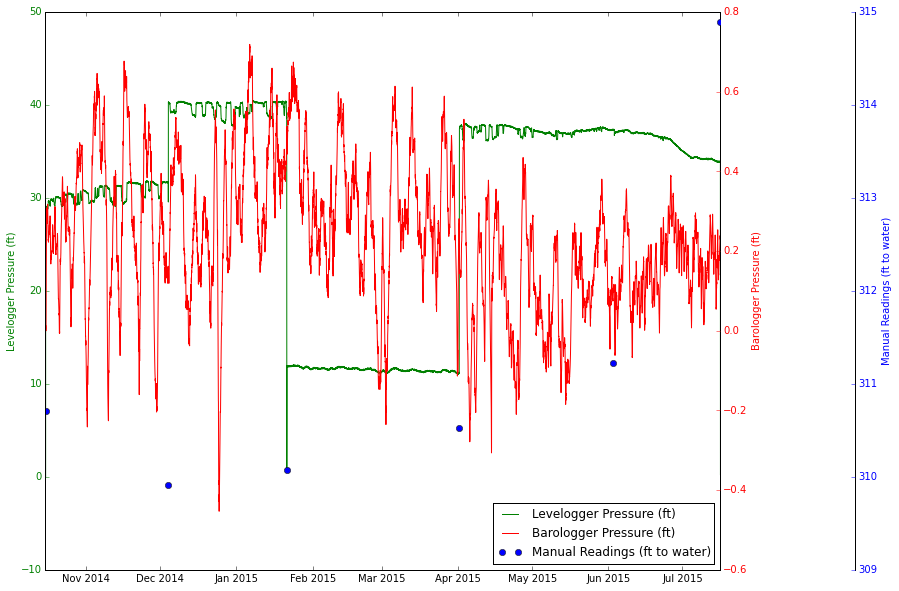

In [262]:
#http://stackoverflow.com/questions/7733693/matplotlib-overlay-plots-with-different-scales
x1 = wellfile.index.to_datetime() #converts pandas dataframe index into datetime format for graph
x2 = barofile.index.to_datetime()
x3 = manualfile.index.to_datetime()

y1 = wellfile['Level']
y2 = barofile['Level']
y3 = manualfile['dtw_ft']

data = [(x1,y1),(x2,y2),(x3,y3)]

fig, ax = plt.subplots()

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx(), ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# Move the last y-axis spine over to the right by 20% of the width of the axes
axes[-1].spines['right'].set_position(('axes', 1.2))

# To make the border of the right-most axis visible, we need to turn the frame
# on. This hides the other plots, however, so we need to turn its fill off.
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)

# And finally we get to plot things...
colors = ['Green', 'Red', 'Blue']
labels = ['Levelogger Pressure (ft)','Barologger Pressure (ft)','Manual Readings (ft to water)' ]
marks = ['','','o']
linetypes = ['solid','solid','none']

for ax, color, datum, label, mark, linety in zip(axes, colors, data, labels, marks, linetypes):
    ax.plot(datum[0],datum[1], marker=mark, linestyle=linety, color=color, label=label)
    ax.set_ylabel(label, color=color)
    ax.tick_params(axis='y', colors=color)
    
h1, l1 = axes[0].get_legend_handles_labels()
h2, l2 = axes[1].get_legend_handles_labels()
h3, l3 = axes[2].get_legend_handles_labels()
axes[0].legend(h1+h2+h3, l1+l2+l3, loc=4)


plt.show()

# Fix Jumps

This tranducer has a jump in the middle of the data caused by adjustments during manual recordings, as well as a jump at the beginning due to the transducer being out of water at the time of measurement.

In [263]:
wellfile = smoother(wellfile, 'Level', 30, 3)
wellfile = smoother(wellfile, 'Conductivity', 30, 3)

                       ch3  Temperature  Conductivity   Level  \
DateTime                                                        
2014-10-15 22:30:00  0.392         11.5        0.3920  28.799   
2014-10-16 13:30:00  0.393         11.5        0.3930  29.016   
2014-10-16 14:00:00  0.393         11.5        0.3930  29.173   
2014-10-16 14:30:00  0.394         11.5        0.3940  29.350   
2014-10-17 08:00:00  0.394         11.5        0.3940  29.193   
2014-10-17 11:30:00  0.394         11.5        0.3940  29.114   
2014-10-17 12:00:00  0.395         11.5        0.3945  29.291   
2014-10-17 13:00:00  0.395         11.5        0.3950  29.547   
2014-10-17 13:30:00  0.395         11.5        0.3950  29.705   
2014-10-19 02:30:00  0.396         11.5        0.3960  29.390   
2014-10-19 03:30:00  0.396         11.5        0.3960  29.232   
2014-10-19 14:00:00  0.397         11.5        0.3970  29.784   
2014-10-23 01:30:00  0.405         11.5        0.4050  29.882   
2014-10-23 03:00:00  0.40

c:\python27\arcgis10.3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


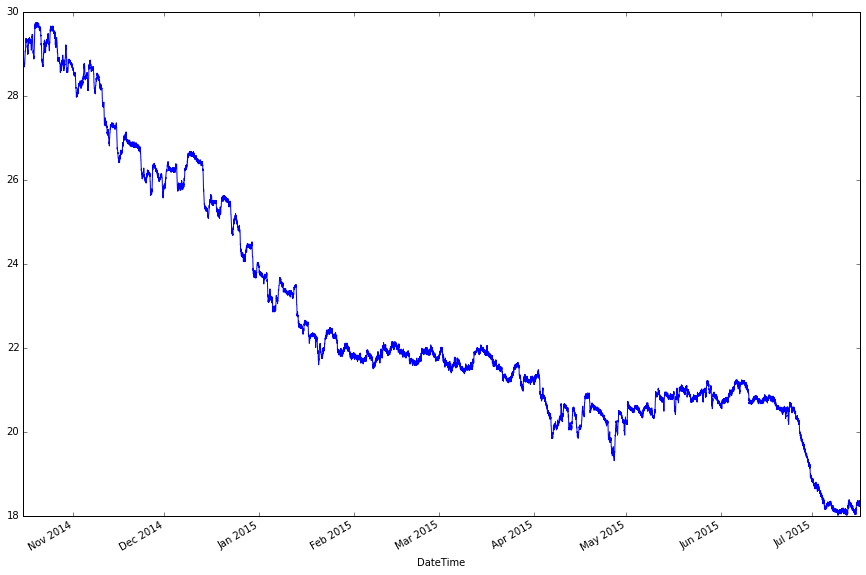

In [264]:
wellfile = jumpfix(wellfile,'Level',0.1)
wellfile = jumpfix(wellfile,'Conductivity',0.005)
wellfile['Level'].plot()

# Remove Barometric Pressure

Solinst transducers are nonvented, meaning that they measure absolute pressure.  When they are submerged in a well, they are measuring the pressure of the water and the atmosphere.  In most cases, we are only interested in the pressure that the water exerts, so we have to subtract the pressure that the atmosphere is exerting.

In [109]:
wellbaro = baro_drift_correct(wellfile,barofile,manualfile)

c:\python27\arcgis10.3\lib\site-packages\ipykernel\__main__.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [110]:
wellbaro.columns

Index([u'level_0', u'Temperature_x', u'Level_x', u'MeasuredLevel_x',
       u'deltaLevel', u'newVal', u'abs_feet_above_levelogger',
       u'Temperature_y', u'Level_y', u'name', u'MeasuredLevel_y',
       u'abs_feet_above_barologger', u'adjusted_levelogger', u'diff_wls',
       u'DeltaLevel', u'MeasuredDTW', u'last_diff_int', u'DriftCorrection',
       u'DTWBelowCasing', u'DTWBelowGroundSurface', u'WaterElevation'],
      dtype='object')

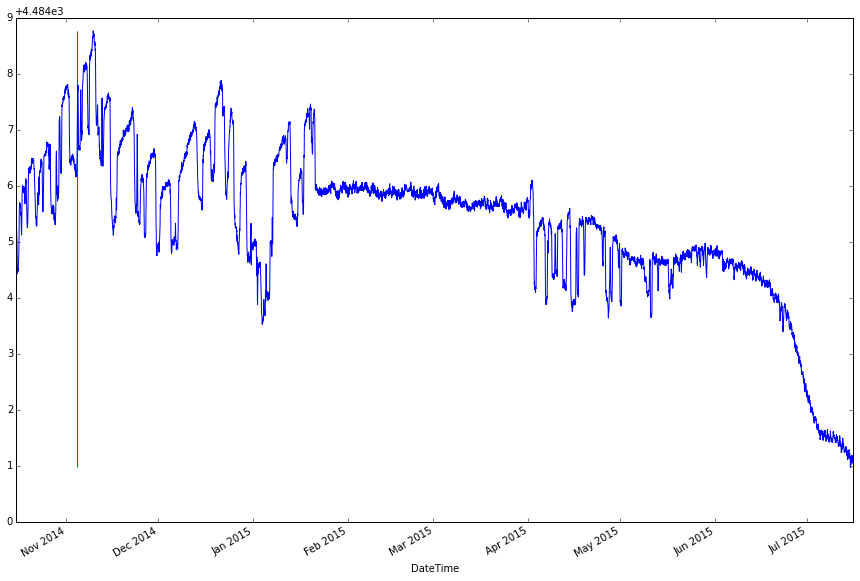

In [250]:
wellbaro['WaterElevation'].plot()
plt.vlines('11/4/2014 11:16',wellbaro['WaterElevation'].min(),wellbaro['WaterElevation'].max(),color='green')

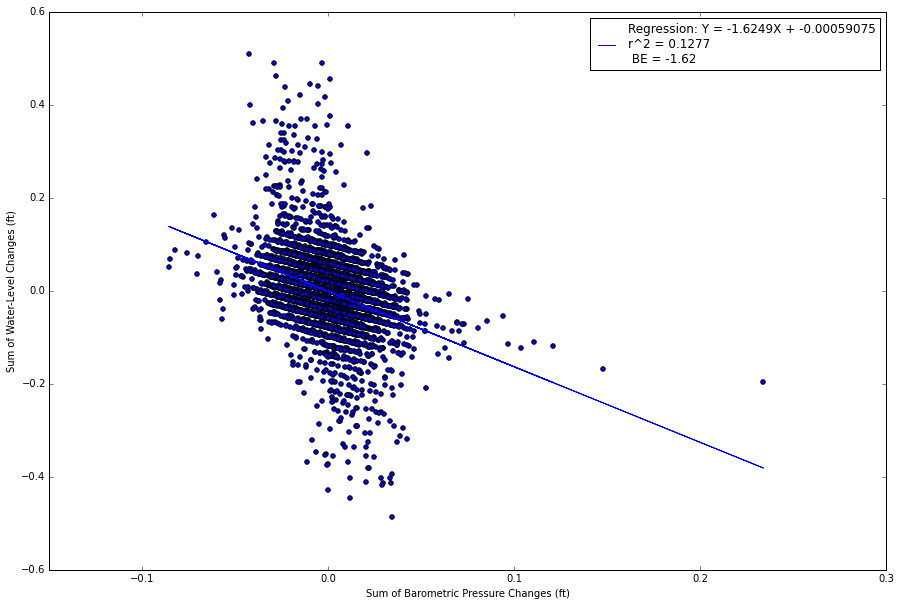

In [112]:
Scat(wellbaro,'abs_feet_above_barologger','WaterElevation')

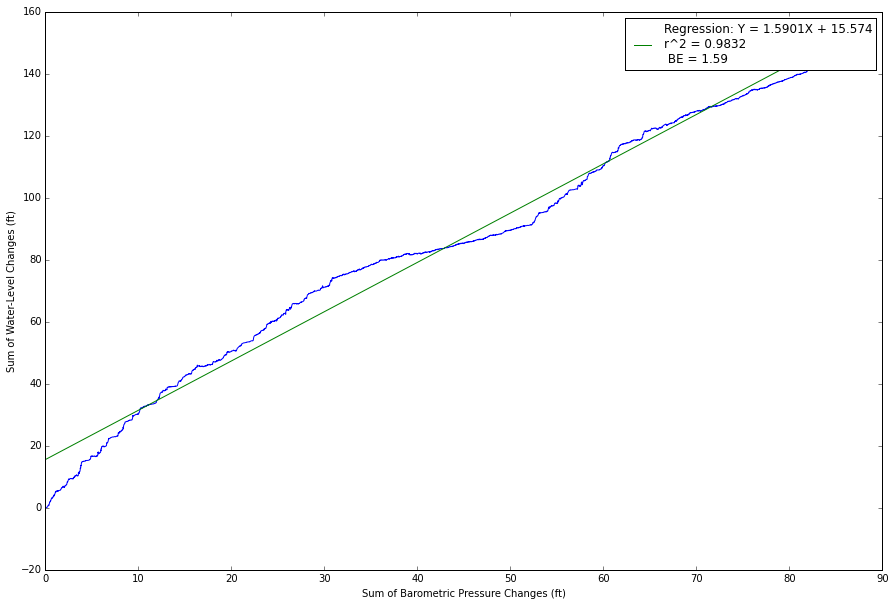

In [113]:
s, m, r = clarks(wellbaro,'abs_feet_above_barologger','WaterElevation')

6561
6561


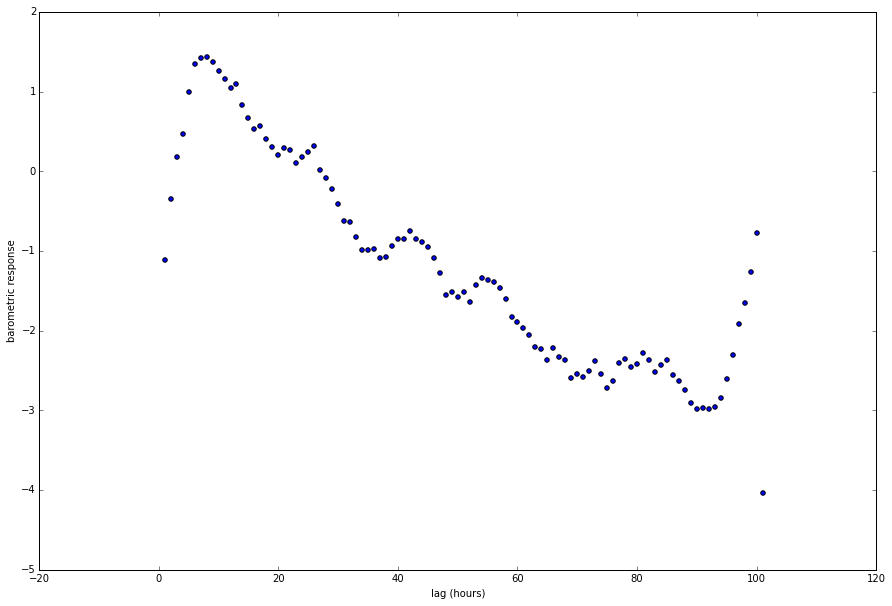

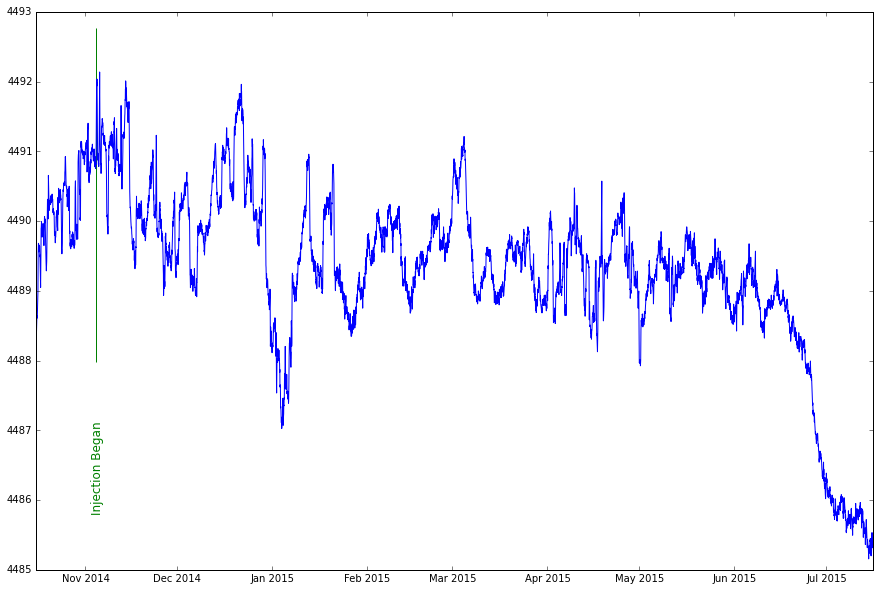

In [257]:
negcumls, cumls, ymod, resid, lag_time, dwl, dbp = baro_eff(wellbaro,'abs_feet_above_barologger','WaterElevation',100)
plt.figure()
lag_trim = lag_time[0:len(negcumls)]
plt.scatter(lag_trim*24,negcumls, label='b.p. alone')
plt.xlabel('lag (hours)')
plt.ylabel('barometric response')

ymin = wellbaro['WaterElevation'].min()

fig, ax = plt.subplots()
plt.plot(wellbaro.index[1:-1], resid)
plt.text(x='11/3/2014 1:00',y=ymin+2,s='Injection Began',rotation=90,color='green',fontsize=12)
y_formatter = tick.ScalarFormatter(useOffset=False)
ax.yaxis.set_major_formatter(y_formatter)
plt.vlines('11/4/2014 11:16',ymin+3,wellbaro['WaterElevation'].max(),color='green')

print len(resid)
print len(wellbaro.index[1:-1])

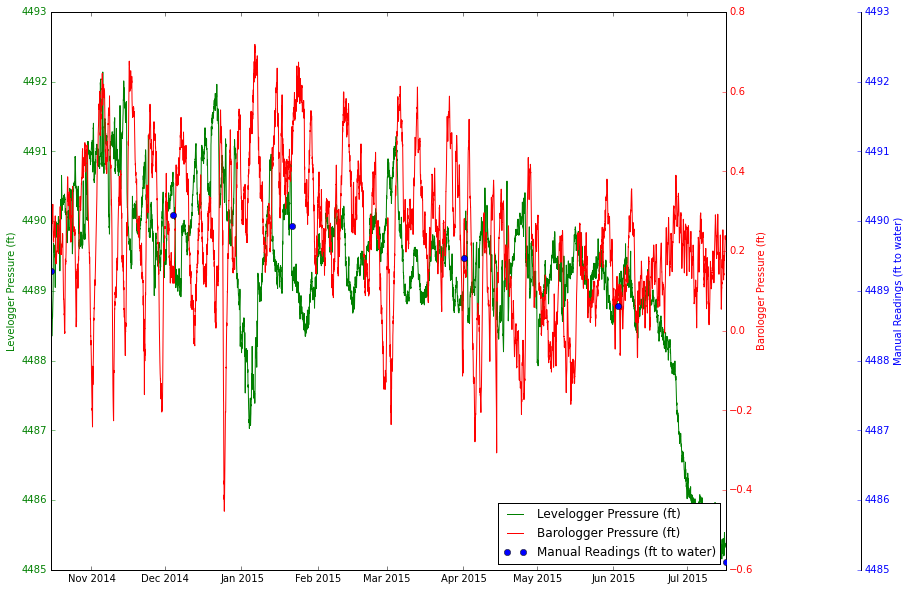

In [138]:
wellbaro['corrwl'] = wellbaro['WaterElevation'] - wellbaro['abs_feet_above_barologger']*1
manualfile['wlelev'] = 4800-manualfile['dtw_ft']

x1 = wellbaro.index.to_datetime()[1:-1] #converts pandas dataframe index into datetime format for graph
x2 = barofile.index.to_datetime()
x3 = manualfile.index.to_datetime()

y1 = resid
y2 = barofile['Level']
y3 = manualfile['wlelev']

data = [(x1,y1),(x2,y2),(x3,y3)]

fig, ax = plt.subplots()

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx(), ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# Move the last y-axis spine over to the right by 20% of the width of the axes
axes[-1].spines['right'].set_position(('axes', 1.2))

# To make the border of the right-most axis visible, we need to turn the frame
# on. This hides the other plots, however, so we need to turn its fill off.
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)

# And finally we get to plot things...
colors = ['Green', 'Red', 'Blue']
labels = ['Levelogger Pressure (ft)','Barologger Pressure (ft)','Manual Readings (ft to water)' ]
marks = ['','','o']
linetypes = ['solid','solid','none']

y_formatter = tick.ScalarFormatter(useOffset=False)

for ax, color, datum, label, mark, linety in zip(axes, colors, data, labels, marks, linetypes):
    ax.plot(datum[0],datum[1], marker=mark, linestyle=linety, color=color, label=label)
    ax.set_ylabel(label, color=color)
    ax.tick_params(axis='y', colors=color)
    ax.yaxis.set_major_formatter(y_formatter)

h1, l1 = axes[0].get_legend_handles_labels()
h2, l2 = axes[1].get_legend_handles_labels()
h3, l3 = axes[2].get_legend_handles_labels()
axes[0].legend(h1+h2+h3, l1+l2+l3, loc=4)
axes[2].set_ylim(4485,4493)


plt.show()

## Match Measurement Interval of Barometer (Barologger) and Transducer  

It is best to set Solinst transducers (Leveloggers) to start at the same time and to measure at the same frequency as your Barologger. Sometimes, this does not happen.  To solve mismatches in sampling interval, we can resample the barometer data to same base (start time) and frequency as the transducer.

Using the `hourly_resample` function above, we can resample each transducer dataset.